In [9]:
# %matplotlib nbagg
# %matplotlib inline
import sys
import os
import time
from datetime import datetime

sys.path.append("..")
# 自分のpath
os.chdir("/home/nakamura/HAI/main_server/hai")

import pymongo
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
from bson.objectid import ObjectId
from sklearn.decomposition import PCA

from _app import app
from database import mongo
from notebooks.utils.utils import visualize, display_latest_image, display_image, print_time, strtime_to_epoch, epoch_to_strtime, pair_images

In [10]:
app.config['PORT_DB']

20202

In [11]:
prints = mongo.print.find({"user_name": "koki", 'time': {"$gt": 1509675690.059450}, 
                           "$or": [{"text": "play"}, {"text": 'study'}, {'text': 'sleep'}, {'text': 'stop'}]}, sort=[("_id", pymongo.ASCENDING)])
prints = list(prints)

In [15]:
# start = '2017-11-01 16:00:07'
# end = '2017-11-01 18:16:56'
# st = strtime_to_epoch(start)
# et = strtime_to_epoch(end)
st = prints[0]['time'] - 0.1
et = prints[-1]['time'] + 0.1

images0 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam0"}, sort=[("_id", pymongo.ASCENDING)])
images1 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam1"}, sort=[("_id", pymongo.ASCENDING)])

In [16]:
data = pair_images(images0)
labels = []
for im0, im1 in data:
    for l in range(len(prints) - 1):
        if prints[l+1]['time'] >= im0['time']:
            labels.append(l)
            break
print(len(data), len(labels))

363 363


<IPython.core.display.Javascript object>


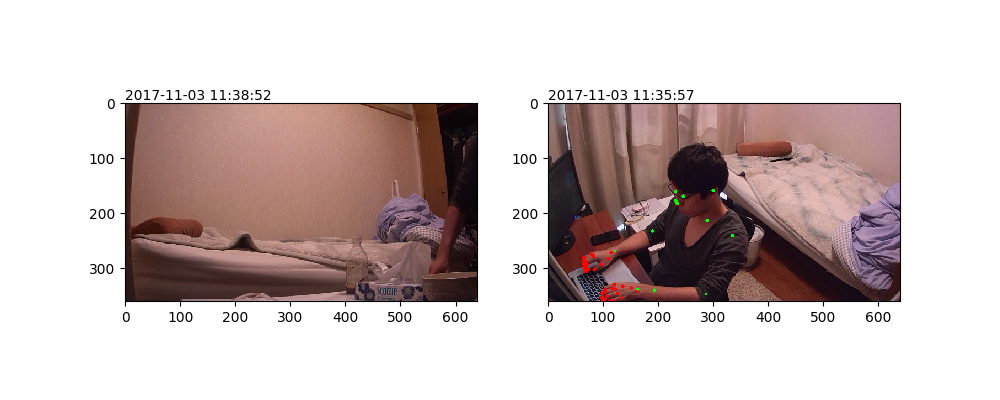

In [8]:
%matplotlib nbagg

num = len(data)
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.set_xticklabels([]) 
axR.set_xticklabels([]) 
axL.set_yticklabels([]) 
axR.set_yticklabels([]) 
axL.grid(False)
axR.grid(False)


def update_plot(i):
    axR.clear()
    im0 = data[i][0]
#     im0_path = app.config['RAW_IMG_DIR'] + im0['filename']
#     img0 = Image.open(im0_path, 'r')
#     axR.imshow(img0)
    axR.imshow(visualize(im0))
    axR.text(0, 1.0, epoch_to_strtime(im0['time']),
             horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    
    axL.clear()
    im1 = data[i][1]
#     im1_path = app.config['RAW_IMG_DIR'] + im1['filename']
#     img1 = Image.open(im1_path, 'r')
#     axL.imshow(img1)
    axL.imshow(visualize(im1))
    axL.text(0, 1.0, epoch_to_strtime(im1['time']),
             horizontalalignment='left',verticalalignment='bottom', transform=axL.transAxes)
    
    return axL, axR


update_plot(0)
ani = animation.FuncAnimation(fig, update_plot, frames=range(num), interval=1000)
# ani.save('data1103.mp4', writer="ffmpeg")
fig.show()

In [18]:
# 0: 勉強
# 1: くつろぎ
# 2: 就寝
# def get_huelabel(t):
#     if t < strtime_to_epoch('2017-11-01 16:05:44'):
#         return 0
#     elif t < strtime_to_epoch('2017-11-01 16:06:44'):
#         return 1
#     elif t < strtime_to_epoch('2017-11-01 16:52:29'):
#         return 2
#     elif t < strtime_to_epoch('2017-11-01 16:57:15'):
#         return 1
#     elif t < strtime_to_epoch('2017-11-01 17:19:15'):
#         return 2
#     elif t < strtime_to_epoch('2017-11-01 17:38:38'):
#         return 1
#     elif t < strtime_to_epoch('2017-11-01 18:10:44'):
#         return 0
#     elif t < strtime_to_epoch('2017-11-01 18:14:12'):
#         return 1
#     else:
#         return 2

In [17]:
X = []
# Y = []
for d in data:
    if ('people' in d[0]['keypoints']) and (len(d[0]['keypoints']['people']) == 1):
        a = np.array(d[0]['keypoints']['people'][0]['pose_keypoints'])
    else:
        a = np.zeros(54)
        
    if ('people' in d[1]['keypoints']) and (len(d[1]['keypoints']['people']) == 1):
        b = np.array(d[1]['keypoints']['people'][0]['pose_keypoints'])
    else:
        b = np.zeros(54)
    
    X.append(np.concatenate((a, b)))
#     Y.append(get_huelabel(d[0]['time']))
        
    

In [19]:
# PCAで2次元に次元削減
pca = PCA(n_components=2)
pca.fit(np.array(X))
X_2d = pca.fit_transform(np.array(X))

In [20]:
X_2d[0]

array([-65.90182308,  30.04466091])

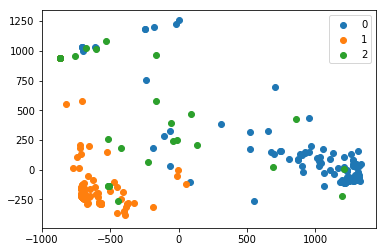

In [21]:
%matplotlib inline
Y = labels
for yl in set(Y):
    indices = [y == yl  for y in Y]
    points = X_2d[indices]
    plt.scatter(points[:, 0], points[:, 1], label=str(yl))
    
plt.legend()
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
clf = LogisticRegression()
cross_validation.cross_val_score(clf, X, Y, cv=5)

array([ 0.75675676,  0.93243243,  0.94444444,  0.98611111,  0.88732394])

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=7)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.93150684931506844

In [29]:
clf.predict(X_test)

array([0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0])

In [31]:
np.array(y_test)

array([0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0])

In [17]:
from imgaug import augmenters as iaa
def augment_images(img_batch, times):
    images = []
    seq = iaa.Sequential([
        iaa.Crop(percent=(0, 0.1)), # random crops
        iaa.Grayscale(alpha=1.0),
        iaa.ContrastNormalization((0.1, 0.9)),
        iaa.Add((-50, 50), True),
#         iaa.Affine(
#             scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#             translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#             rotate=(-25, 25),
#             shear=(-8, 8)
#         )
    ], random_order=True)

    for i in range(times):
        print("{}/{}".format(i, times))
        images_aug = seq.augment_images(img_batch)
        images.extend(images_aug)
        
    return images


0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


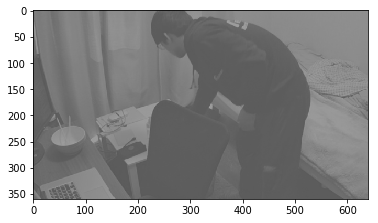

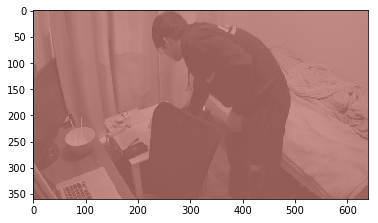

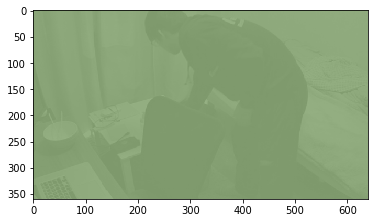

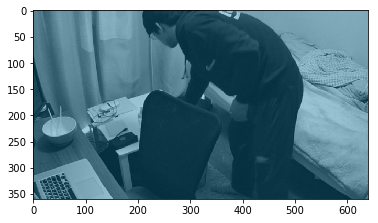

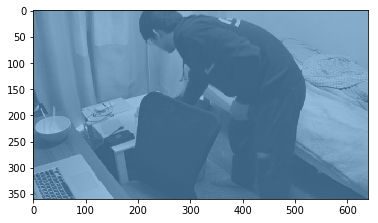

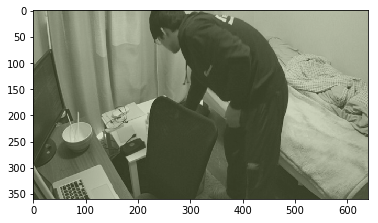

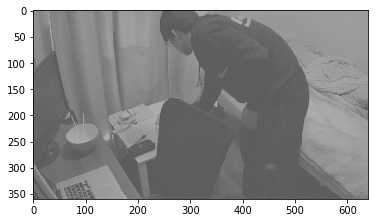

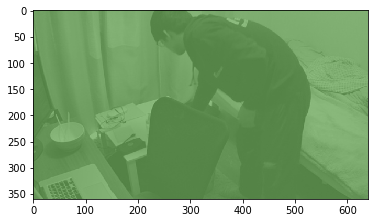

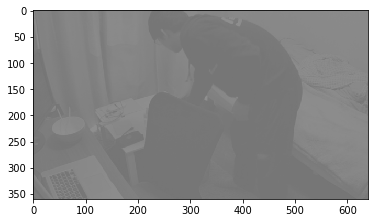

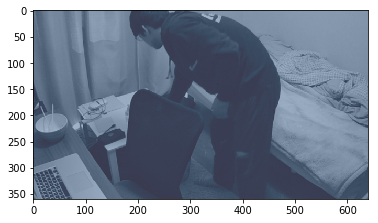

In [19]:
# %matplotlib inline
img_batch = [np.array(Image.open(app.config['RAW_IMG_DIR'] + data[0][0]['filename']))]
aug_imgs = augment_images(img_batch, 10)
def show_images(imgs):
    for img in imgs:
        plt.figure()
        plt.imshow(img)
        plt.show()

show_images(aug_imgs)